# Predict next transaction day

Inspired by [this](https://www.opendoor.com/w/blog/liquidity-modeling-real-estate-survival-analysis) [talk](https://www.youtube.com/watch?v=uU1u6JQCg5U) on hazard models and the poor performance of using Regression to predict next purchase day in the Customer Lifetime Value modelling notebook, an attempt is made here to fit a Proportional Hazards model using Logistic Regression in order to perform the forecasting instead. 

The model doesn't perform particularly well and a few reasons are discussed for why this might be the case (mainly the lack of at least a whole year of data).

By Wong Tran

### Notes

- "merge with customers who made at least 1 transaction in the holdout period" will need to be replaced with "didn't purchase in the next month" in the real deal

<img src ="data/figures/survival.png" width=650>

In [4]:
import gc
import time
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import scikitplot as skplt
from dateutil.relativedelta import *
from scipy.stats import bernoulli
from contextlib import contextmanager
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score
from sklearn.ensemble import RandomForestClassifier
from lifetimes.utils import summary_data_from_transaction_data
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline

In [5]:
@contextmanager
def timer(name):
    time_before_func_call = time.time()
    yield
    time_after_func_call = time.time()
    print('{} - done in {:.0f}s'.format(name, time_after_func_call - time_before_func_call))

<br>
<br>

# Preprocessing

In [18]:
def rename_columns(invoices: pd.DataFrame) -> pd.DataFrame:
    invoices = invoices.copy()
    column_names = list(invoices.columns)
    if 'Customer ID' in column_names:
        invoices = invoices.rename(columns={'Customer ID':'CustomerID'})
    if 'Invoice' in column_names:
        invoices = invoices.rename(columns={'Invoice':'InvoiceNo'})
    if 'Price' in column_names:
        invoices = invoices.rename(columns={'Price':'UnitPrice'})
    
    return invoices


def concat_invoice_dataframes(invoices1: pd.DataFrame, invoices2:pd.DataFrame) -> pd.DataFrame:
    invoices1, invoices2 = invoices1.copy(), invoices2.copy()
    end_of_overlap_period = '2010-12-10'  # Specific to the two UCI online retail datasets
    
    if invoices1.InvoiceDate.max() > invoices2.InvoiceDate.max():
        invoices1 = invoices1[invoices1.InvoiceDate>end_of_overlap_period]
        invoices = pd.concat([invoices2, invoices1])
    else:
        invoices2 = invoices2[invoices2.InvoiceDate>end_of_overlap_period]
        invoices = pd.concat([invoices1, invoices2])
    
    return invoices
    
    
def add_revenue_column(invoices: pd.DataFrame) -> pd.DataFrame:
    invoices = invoices.copy()
    if "Revenue" not in list(invoices.columns):
        invoices['Revenue'] = invoices['UnitPrice'] * invoices['Quantity']
    
    return invoices


def drop_test_invoices(invoices: pd.DataFrame) -> pd.DataFrame:
    invoices = invoices.copy()
    test_invoice_indexs = invoices[invoices['StockCode'].str.contains('TEST', na=False)].index
    invoices = invoices.drop(index=test_invoice_indexs)
    
    return invoices


def drop_cancellation_invoices(invoices: pd.DataFrame) -> pd.DataFrame:
    invoices = invoices.copy()
    cancellation_invoice_indexs = invoices[invoices.InvoiceNo.str.contains('c', na=False, case=False)].index
    invoices = invoices.drop(index=cancellation_invoice_indexs)

    return invoices


def drop_return_invoices(invoices: pd.DataFrame) -> pd.DataFrame:
    invoices = invoices.copy()
    invoices = invoices[invoices['UnitPrice']>0].copy()
    
    return invoices

def drop_non_numeric_invoice_numbers(invoices: pd.DataFrame) -> pd.DataFrame:
    invoices = invoices.copy()
    invoices = invoices[pd.to_numeric(invoices['InvoiceNo'], errors='coerce').notna()]
    return invoices


def get_observation_end_dates(invoices: pd.DataFrame) -> list:
    first_invoice_date = invoices.InvoiceDate.min().date()
    last_invoice_date = invoices.InvoiceDate.max().date()
    time_difference = relativedelta(last_invoice_date, first_invoice_date)
    num_months = time_difference.years * 12 + time_difference.months
    observation_end_dates = [first_invoice_date+relativedelta(months=month_num) for month_num in range(0,num_months+1)]
    observation_end_dates = observation_end_dates[2:-1]
    
    return observation_end_dates


def train_split_invoices_into_calib_holdout(observation_period_end: pd.datetime, invoices: pd.DataFrame):
    calib_period_end = observation_period_end - relativedelta(months=1)
    calib_invoices = invoices[invoices.InvoiceDate<=calib_period_end].copy()
    holdout_invoices = invoices[invoices.InvoiceDate>calib_period_end].copy()
    
    return calib_invoices, holdout_invoices, calib_period_end
 
    
def test_split_invoices_into_calib_holdout(observation_period_end: pd.datetime, invoices: pd.DataFrame):
    calib_period_end = observation_period_end
    calib_invoices = invoices[invoices.InvoiceDate<=calib_period_end].copy()
    holdout_invoices = invoices[invoices.InvoiceDate>calib_period_end].copy()
    
    return calib_invoices, holdout_invoices, calib_period_end


def get_aggregation_features(calib_invoices):
    calib_invoices = calib_invoices.copy()
    calib_invoices['InvoiceDay'] = calib_invoices['InvoiceDate'].dt.date
    calib_single_daily_invoices = calib_invoices.drop_duplicates(subset=['CustomerID', 'InvoiceDay'], keep='first')
    calib_single_daily_invoices = calib_single_daily_invoices.sort_values(by=['CustomerID', 'InvoiceDate'])
    
    calib_single_daily_invoices['PrevInvoiceDate'] = calib_single_daily_invoices.groupby('CustomerID')['InvoiceDate'].shift(1)
    calib_single_daily_invoices['TimeBetweenInvoices'] = (calib_single_daily_invoices['InvoiceDate'] - calib_single_daily_invoices['PrevInvoiceDate']).dt.days
    aggregation_features = calib_single_daily_invoices.groupby('CustomerID')['TimeBetweenInvoices'].agg(['mean', 'std', 'min', 'max']).reset_index()
    aggregation_features.columns = ['CustomerID', 'MeanTimeBetweenPurchase', 'StDevTimeBetweenPurchase', 'MinTimeBetweenPurchase', 'MaxTimeBetweenPurchase'] 
    
    features = calib_invoices[['CustomerID']].drop_duplicates().sort_values(by='CustomerID').reset_index(drop=True).copy()
    features = features.merge(aggregation_features, how='left', on='CustomerID')
    features = features.dropna()  # Customers who purchased at least 3 times during calibration period
    
    return features


def add_rfm_features(features, calib_invoices, period_end):
    features = features.copy()
    rfm_features = summary_data_from_transaction_data(
        transactions=calib_invoices,
        customer_id_col='CustomerID',
        datetime_col='InvoiceDate',
        monetary_value_col='Revenue',
        observation_period_end=period_end,
        freq='D'
    )
    rfm_features['T_Minus_Recency'] = rfm_features['T'] - rfm_features['recency']
    features = features.merge(rfm_features, how='left', on='CustomerID')
    
    return features


def add_cyclical_last_invoice_date_feature(features, calib_invoices):
    features = features.copy()
    customers_last_calib_invoices = calib_invoices.groupby("CustomerID")['InvoiceDate'].max().reset_index()
    customers_last_calib_invoices.columns = ['CustomerID', 'LastCalibPurchase']
    customers_last_calib_invoices['CurrentDayOfYear'] = customers_last_calib_invoices['LastCalibPurchase'].apply(lambda x: x.timetuple().tm_yday)
    customers_last_calib_invoices['CurrentDayOfYear_sin'] = np.sin(2 * np.pi * customers_last_calib_invoices['CurrentDayOfYear'] / 365)
    customers_last_calib_invoices['CurrentDayOfYear_cos'] = np.cos(2 * np.pi * customers_last_calib_invoices['CurrentDayOfYear'] / 365)
    customers_last_calib_invoices.drop(columns=['CurrentDayOfYear', 'LastCalibPurchase'], inplace=True)
    features = features.merge(customers_last_calib_invoices, how='left', on='CustomerID')
    
    return features


def add_uk_feature(features, calib_invoices):
    uk_or_not = calib_invoices[['CustomerID', 'Country']].drop_duplicates(subset=['CustomerID']).copy()
    uk_or_not['UK'] = uk_or_not['Country'] == 'United Kingdom'
    uk_or_not = uk_or_not.drop(columns='Country')
    features = features.merge(uk_or_not, how='left', on='CustomerID')
    
    return features

    
def get_labels(features, calib_invoices, holdout_invoices, period_end):
    customer_last_calib_purchases = calib_invoices.groupby("CustomerID")['InvoiceDate'].max().reset_index()
    customer_first_holdout_purchases = holdout_invoices.groupby("CustomerID")['InvoiceDate'].min().reset_index()
    labels = customer_last_calib_purchases.merge(customer_first_holdout_purchases, how='left', on='CustomerID')
    labels.columns = ['CustomerID', 'LastCalibPurchase', 'FirstHoldoutPurchase']
    labels['PurchaseNextMonth'] = \
    (labels['FirstHoldoutPurchase'] >= period_end) & \
    (labels['FirstHoldoutPurchase'] < period_end + relativedelta(months=1))
    labels = labels.drop(columns = ['LastCalibPurchase',  'FirstHoldoutPurchase'])
    labels = labels[labels.CustomerID.isin(features.CustomerID)]
    
    return labels

def _get_train_test_data(invoices, observation_end_date):
    train_calib_invoices, train_holdout_invoices, train_calib_period_end = train_split_invoices_into_calib_holdout(observation_end_date, invoices)
    test_calib_invoices, test_holdout_invoices, test_calib_period_end = test_split_invoices_into_calib_holdout(observation_end_date, invoices)

    train_features = get_aggregation_features(train_calib_invoices)
    train_features = add_rfm_features(train_features, train_calib_invoices, train_calib_period_end)
    #train_features = add_uk_feature(train_features, train_calib_invoices)
    train_features = add_cyclical_last_invoice_date_feature(train_features, train_calib_invoices)

    test_features = get_aggregation_features(test_calib_invoices)
    test_features = add_rfm_features(test_features, test_calib_invoices, test_calib_period_end)
    #test_features = add_uk_feature(test_features, test_calib_invoices)
    test_features = add_cyclical_last_invoice_date_feature(test_features, test_calib_invoices)

    train_labels = get_labels(train_features, train_calib_invoices, train_holdout_invoices, train_calib_period_end)
    test_labels = get_labels(test_features, test_calib_invoices, test_holdout_invoices, test_calib_period_end)

    X_train = train_features.drop(columns='CustomerID')
    X_test = test_features.drop(columns='CustomerID')
    y_train = train_labels['PurchaseNextMonth'].copy()
    y_test = test_labels['PurchaseNextMonth'].copy()
     
    return X_train, y_train, X_test, y_test


def get_naive_labels(invoices, observation_end_dates):
    
    naive_labels = dict(
        y_train=[],
        y_test=[],
    )
    
    for observation_end_date in observation_end_dates:
        train_calib_invoices, _, _ = train_split_invoices_into_calib_holdout(observation_end_date, invoices)
        test_calib_invoices, _, _ = test_split_invoices_into_calib_holdout(observation_end_date, invoices)

        train_features = get_aggregation_features(train_calib_invoices)
        test_features = get_aggregation_features(test_calib_invoices)

        days_in_a_month = 30.4167
        naive_labels['y_train'].append(train_features['MeanTimeBetweenPurchase']<days_in_a_month)
        naive_labels['y_test'].append(test_features['MeanTimeBetweenPurchase']<days_in_a_month)

    return naive_labels


def train_models(ModelClass, invoices, observation_end_dates, **kwargs):
    train_results = dict(
        models=[], 
        observation_end_dates=observation_end_dates,
        X_train=[],
        y_train=[],
        X_test=[],
        y_test=[],
    )
    
    for observation_end_date in observation_end_dates:
        X_train, y_train, X_test, y_test = _get_train_test_data(invoices, observation_end_date)
        model = ModelClass(**kwargs)
        model.fit(X_train, y_train)
        train_results['models'].append(model)
        train_results['X_train'].append(X_train)
        train_results['y_train'].append(y_train)
        train_results['X_test'].append(X_test)
        train_results['y_test'].append(y_test)

    return train_results

def evaluate_models(train_results, naive_labels, metric='accuracy', average=False):
    evaluation_method = dict(accuracy=accuracy_score, precision=precision_score)
    train_evals, test_evals = [], []
    
    
    for model, X_train, y_train, X_test, y_test, observation_end_date, y_naive_train, y_naive_test in zip(
        train_results['models'],
        train_results['X_train'], 
        train_results['y_train'],
        train_results['X_test'],
        train_results['y_test'],
        train_results['observation_end_dates'],
        naive_labels['y_train'],
        naive_labels['y_test'],
    ):
        
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        train_eval = round(evaluation_method[metric](y_train, y_pred_train), 3)
        test_eval = round(evaluation_method[metric](y_test, y_pred_test), 3)
        naive_train_eval = round(evaluation_method[metric](y_train, y_naive_train), 3)
        naive_test_eval = round(evaluation_method[metric](y_test, y_naive_test), 3)
        train_evals.append(train_eval)
        test_evals.append(test_eval)
            
        if not average:
            print(f"observation period end: {observation_end_date}\n"
                  f"train {metric}: {train_eval}, test {metric}: {test_eval}\n"
                  f"naive train {metric}: {naive_train_eval}, (naive) test {metric}: {naive_test_eval}")
            print("---")
    
    if average:
        mean_train_eval, mean_test_eval = round(np.mean(train_evals), 3), round(np.mean(test_evals), 3)
        print(f"average train {metric}: {mean_train_eval}, average test {metric}: {mean_test_eval}")

        
def evaluate_models_by_plotting(train_results, naive_labels, metric='accuracy'):
    evaluation_method = dict(accuracy=accuracy_score, precision=precision_score)
    train_metrics, test_metrics, naive_test_metrics = [], [], []
    observation_end_dates = train_results['observation_end_dates']
    
    for model, X_test, y_test, observation_end_date, y_naive_test in zip(
        train_results['models'],
        train_results['X_test'],
        train_results['y_test'],
        train_results['observation_end_dates'],
        naive_labels['y_test'],
    ):
        y_pred_test = model.predict(X_test)
        test_eval = round(evaluation_method[metric](y_test, y_pred_test), 3)
        naive_test_eval = round(evaluation_method[metric](y_test, y_naive_test), 3)
        test_metrics.append(test_eval)
        naive_test_metrics.append(naive_test_eval)
        #baseline.append(y_test.value_counts().max()/len(y_test))
        
    
    fig = plt.figure(figsize=(9,6))
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel('Observation Period End')
    color = 'tab:red'
    ax1.set_ylabel('Test {}'.format(metric), color=color)
    ax1.plot(observation_end_dates, test_metrics, color=color, label='Test accuracy')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(alpha=0.3)
    ax1.set_ylim(0.4,1.0)
    ax1.set_title('{} of predictions'.format(metric))
    
    color = 'tab:blue'
    ax2 = ax1.twinx() 
    ax2.set_ylabel('Test {} of naive model'.format(metric), color=color) 
    ax2.plot(observation_end_dates, naive_test_metrics, color=color, label='Majority label classifier')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0.4,1.0)

<br>
<br>

In [7]:
with timer("Read invoice data"):
    invoices_2011 = pd.read_excel("data/retail/Online_Retail.xlsx")
    invoices_2010 = pd.read_excel("data/retail/online_retail_II.xlsx")

Read invoice data - done in 112s


In [10]:
with timer("Preprocess invoice dataframes"):
    invoices_2010 = rename_columns(invoices_2010)
    invoices = concat_invoice_dataframes(invoices_2010, invoices_2011)
    invoices = add_revenue_column(invoices)
    invoices = drop_test_invoices(invoices)
    invoices = drop_cancellation_invoices(invoices)
    invoices = drop_return_invoices(invoices)
    invoices = drop_non_numeric_invoice_numbers(invoices)
      
with timer("Get observation period end dates"):
    observation_end_dates = get_observation_end_dates(invoices)
    
with timer("Get naive labels"):
    naive_labels = get_naive_labels(invoices, observation_end_dates)

with timer("Train models"):
    train_results = train_models(RandomForestClassifier, invoices, observation_end_dates, n_estimators=1500, max_depth=7, n_jobs=6)

Preprocess invoice dataframes - done in 3s
Get observation period end dates - done in 0s
Get naive labels - done in 17s
Train models - done in 78s


In [19]:
with timer("Evaluate models"):
    evaluate_models(train_results, naive_labels, 'accuracy', average=False)

observation period end: 2010-02-01
train accuracy: 1.0, test accuracy: 0.623
naive train accuracy: 0.75, (naive) test accuracy: 0.667
---
observation period end: 2010-03-01
train accuracy: 0.962, test accuracy: 0.585
naive train accuracy: 0.667, (naive) test accuracy: 0.656
---
observation period end: 2010-04-01
train accuracy: 0.932, test accuracy: 0.638
naive train accuracy: 0.656, (naive) test accuracy: 0.644
---
observation period end: 2010-05-01
train accuracy: 0.928, test accuracy: 0.627
naive train accuracy: 0.644, (naive) test accuracy: 0.612
---
observation period end: 2010-06-01
train accuracy: 0.942, test accuracy: 0.617
naive train accuracy: 0.612, (naive) test accuracy: 0.6
---
observation period end: 2010-07-01
train accuracy: 0.879, test accuracy: 0.678
naive train accuracy: 0.6, (naive) test accuracy: 0.654
---
observation period end: 2010-08-01
train accuracy: 0.807, test accuracy: 0.673
naive train accuracy: 0.654, (naive) test accuracy: 0.628
---
observation period e

Evaluate models by plotting - done in 7s


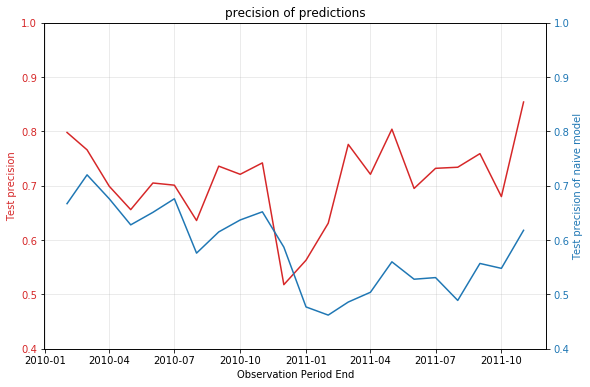

In [12]:
with timer("Evaluate models by plotting"):
    evaluate_models_by_plotting(train_results, naive_labels, metric='precision')

<br>
<br>

# Stacking Classifier

In [4]:
with timer("Read invoice data"):
    invoices_2011 = pd.read_excel("data/retail/Online_Retail.xlsx")
    invoices_2010 = pd.read_excel("data/retail/online_retail_II.xlsx")

Read invoice data - done in 116s


In [ ]:
with timer("Preprocess invoice dataframes"):
    invoices_2010 = rename_columns(invoices_2010)
    invoices = concat_invoice_dataframes(invoices_2010, invoices_2011)
    invoices = add_revenue_column(invoices)
    invoices = drop_test_invoices(invoices)
    invoices = drop_cancellation_invoices(invoices)
    invoices = drop_return_invoices(invoices)
      
with timer("Get observation period end dates"):
    observation_end_dates = get_observation_end_dates(invoices)
    
with timer("Get naive labels"):
    naive_labels = get_naive_labels(invoices, observation_end_dates)

with timer("Train models"):
    estimators = [
    ('rf', RandomForestClassifier(n_estimators=1000, max_depth=7, n_jobs=6)),
    ('lr', make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000)))
]
    
    train_results = train_models(
        StackingClassifier,
        invoices,
        observation_end_dates,
        estimators=estimators,
        final_estimator=LinearSVC()
    )
    
with timer("Evaluate models"):
    evaluate_models(train_results, naive_labels, 'accuracy')

In [9]:
with timer("Evaluate models"):
    evaluate_models(train_results, naive_labels, 'accuracy', average=True)

average train accuracy: 0.767, average test accuracy: 0.696
Evaluate models - done in 9s


<br>
<br>

In [ ]:
X_train, y_train, X_test, y_test = _get_train_test_data(invoices, observation_end_dates[10])
model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
model.fit(X_train, y_train)
train_results['models'].append(model)
train_results['X_train'].append(X_train)
train_results['y_train'].append(y_train)
train_results['X_test'].append(X_test)
train_results['y_test'].append(y_test)

<br>
<br>

              precision    recall  f1-score   support

       False       0.80      0.96      0.88      1714
        True       0.84      0.43      0.57       711

    accuracy                           0.81      2425
   macro avg       0.82      0.70      0.72      2425
weighted avg       0.81      0.81      0.79      2425


              precision    recall  f1-score   support

       False       0.80      0.96      0.87      1843
        True       0.74      0.34      0.46       674

    accuracy                           0.79      2517
   macro avg       0.77      0.65      0.67      2517
weighted avg       0.78      0.79      0.76      2517



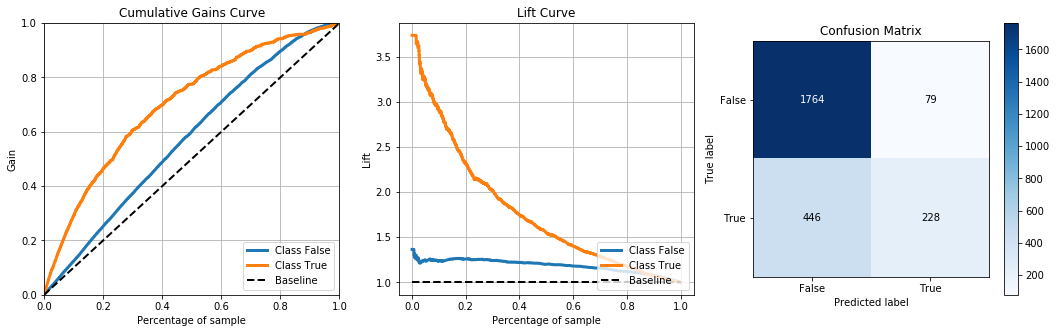

In [90]:
grid_search=False

#######

if grid_search:
    rf = RandomForestClassifier(n_estimators=800, n_jobs=3)
    param_grid = {
        'max_depth':list(range(3,16)),
        'min_samples_split':list(range(2,20,2)),
        'max_features':['auto', 'sqrt']
    }
    rf_gs = GridSearchCV(rf, param_grid, scoring='accuracy', n_jobs=3, iid=False, cv=6)
    rf_gs.fit(X_train, y_train)
    best_rf = rf_gs.best_estimator_
    best_rf.fit(X_train, y_train)
    y_pred_train = best_rf.predict(X_train)
    y_pred_test = best_rf.predict(X_test)
else:
    rf = RandomForestClassifier(n_estimators=1000, max_depth=7, n_jobs=6)
    rf.fit(X_train, y_train)
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)

#######
    
print(classification_report(y_train, y_pred_train))
print()
print(classification_report(y_test, y_pred_test))

y_probas = rf.predict_proba(X_test)
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(131)
skplt.metrics.plot_cumulative_gain(y_test, y_probas, ax=ax)
ax = fig.add_subplot(132)
skplt.metrics.plot_lift_curve(y_test, y_probas, ax=ax)
ax = fig.add_subplot(133)
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, ax=ax);

<br>
<br>

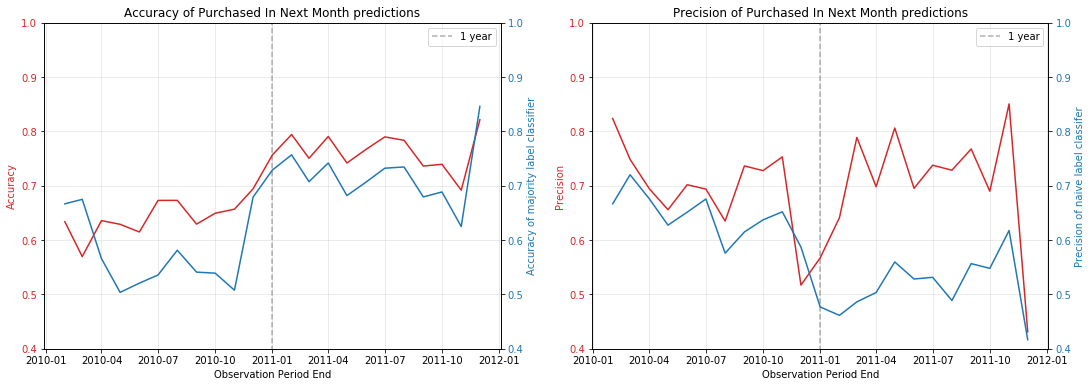

In [85]:
precs, accs, months, positive_preds, test_points, baseline, baseline_prec = [], [], [], [], [], [], []
#pos_model = 'coin flip'
#pos_model = 'prev month'
pos_model = 'mean naive'

for y in [2010, 2011]:
    for m in range(1, 13):
        if (y==2010) & (m==1):
            continue
        months.append(pd.datetime(year=y, month=m, day=1))
        X_train, X_test, y_train, y_test, naive_preds = get_train_test_data(
            transaction_df=transaction_df,
            observation_period_end=pd.datetime(y,m,1),
            day_feats=True,
            get_holiday_feat=True,
            get_date_feats=True,
            get_april_train_data=True,
            return_naive_preds=True,
            mean_as_naive_preds=True if pos_model=='mean naive' else False
        )
        
        rf = RandomForestClassifier(n_estimators=1000, max_depth=7, n_jobs=6)
        rf.fit(X_train, y_train)
        y_pred_train = rf.predict(X_train)
        y_pred_test = rf.predict(X_test)
        
        precs.append(precision_score(y_test, y_pred_test))
        accs.append(accuracy_score(y_test, y_pred_test))
        test_points.append(len(y_test))
        baseline.append(y_test.value_counts().max()/len(y_test))
        positive_preds.append(np.sum(y_pred_test==1))
        if pos_model == 'coin flip':
            baseline_prec.append(precision_score(y_test, bernoulli.rvs(p=y_train.sum()/len(y_train), size=len(y_test))))
        else:
            baseline_prec.append(precision_score(y_test, naive_preds))

fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121)
color = 'tab:red'
ax1.set_xlabel('Observation Period End')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(months, accs, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(alpha=0.3)
ax1.vlines(pd.datetime(2011,1,1), 0, 1.5, linestyles='dashed', alpha=0.3, label='1 year')
ax1.set_ylim(0.4,1.0)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy of majority label classifier', color=color) 
ax2.plot(months, baseline, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.legend()
ax1.set_title('Accuracy of Purchased In Next Month predictions')
ax2.set_ylim(0.4,1.0)

ax1 = fig.add_subplot(122)
color = 'tab:red'
ax1.set_xlabel('Observation Period End')
ax1.set_ylabel('Precision', color=color)
ax1.plot(months, precs, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(alpha=0.3)
ax1.vlines(pd.datetime(2011,1,1), 0, 1.5, linestyles='dashed', alpha=0.3, label='1 year')
ax1.set_ylim(0.4,1.0)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Precision of naive label classifer', color=color) 
ax2.plot(months, baseline_prec, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0.4,1.0)
ax1.legend()
ax1.set_title('Precision of Purchased In Next Month predictions')
plt.tight_layout;

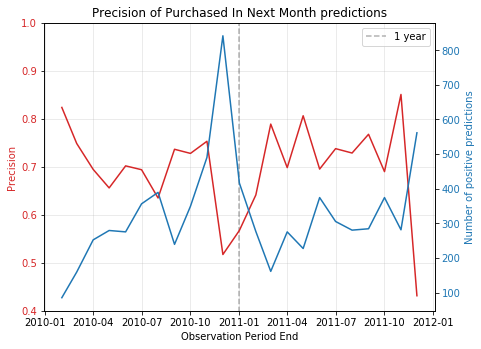

In [84]:
fig = plt.figure(figsize=(7,5.3))
ax1 = fig.add_subplot(111)
color = 'tab:red'
ax1.set_xlabel('Observation Period End')
ax1.set_ylabel('Precision', color=color)
ax1.plot(months, precs, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(alpha=0.3)
ax1.vlines(pd.datetime(2011,1,1), 0, 1.5, linestyles='dashed', alpha=0.3, label='1 year')
ax1.set_ylim(0.4,1.0)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Number of positive predictions', color=color) 
ax2.plot(months, positive_preds, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.legend()
ax1.set_title('Precision of Purchased In Next Month predictions');

<br>
<br>

In [174]:
transaction_df[(transaction_df['InvoiceDate'].dt.month==12) & (transaction_df['InvoiceDate'].dt.year==2011)]['CustomerID'].nunique()

559

In [173]:
transaction_df['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

___

<br>
<br>

In [127]:
def get_train_test_data(
    transaction_df=invoices,
    observation_period_end=pd.datetime(2011,6,1),
    day_feats=False,
    get_holiday_feat=False,
    get_date_feats=False,
    get_april_train_data=False,
    return_naive_preds=False,
    mean_as_naive_preds=False
):

# observation_period_end=pd.datetime(2011,6,1)
# day_feats=True
# get_holiday_feat=True
# get_date_feats=True
# get_april_train_data=False

    # Train on data 1 month prior
    train_t_cutoff = observation_period_end - relativedelta(months=1)
    train_transaction_df_calib = transaction_df[transaction_df.InvoiceDate<=train_t_cutoff]
    train_transaction_df_holdout = transaction_df[transaction_df.InvoiceDate>train_t_cutoff]

    # Customer's last transaction during the calibration period
    train_df = train_transaction_df_calib.groupby("CustomerID")['InvoiceDate'].max().reset_index()

    # Merge with customer's who also made at least 1 transaction in holdout period 
    train_df = train_df.merge(
        train_transaction_df_holdout.groupby("CustomerID")['InvoiceDate'].min().reset_index(),
        how = 'left',
        on = 'CustomerID'
    )
    train_df.columns = ['CustomerID', 'LastCalibPurchase', 'FirstHoldoutPurchase']

    # Get train_label, Customers who did not purchase in the holdout period will have a negative label
    train_df['PurchasedInNextMonth'] = (train_df['FirstHoldoutPurchase'] >= train_t_cutoff) & (train_df['FirstHoldoutPurchase'] < train_t_cutoff + relativedelta(months=1))

    # Test data
    test_t_cutoff = observation_period_end
    test_transaction_df_calib = transaction_df[transaction_df.InvoiceDate<=test_t_cutoff]
    test_transaction_df_holdout = transaction_df[transaction_df.InvoiceDate>test_t_cutoff]

    # Customer's last transaction during the calibration period
    test_df = test_transaction_df_calib.groupby("CustomerID")['InvoiceDate'].max().reset_index()

    # Merge with customer's who also made at least 1 transaction in holdout period
    test_df = test_df.merge(
        test_transaction_df_holdout.groupby("CustomerID")['InvoiceDate'].min().reset_index(),
        how = 'left',
        on = 'CustomerID'
    )
    test_df.columns = ['CustomerID', 'LastCalibPurchase', 'FirstHoldoutPurchase']

    # Get test_label. Customers who did not purchase in the holdout period will have a negative label
    test_df['PurchasedInNextMonth'] = (test_df['FirstHoldoutPurchase'] >= test_t_cutoff) & (test_df['FirstHoldoutPurchase'] < test_t_cutoff + relativedelta(months=1))
      
    # Predict that customers who purchased last month will purchase next month - for precision evaluation
    if return_naive_preds & (not mean_as_naive_preds):  
        last_month_purchases = train_df[['CustomerID', 'PurchasedInNextMonth']].copy()
    
    # Get agg training features
    train_calib_daily_transactions = train_transaction_df_calib[train_transaction_df_calib['CustomerID'].isin(train_df['CustomerID'])][['CustomerID','InvoiceDate']].copy()
    train_calib_daily_transactions['InvoiceDay'] = train_calib_daily_transactions['InvoiceDate'].dt.date
    train_calib_daily_transactions.drop_duplicates(subset=['CustomerID', 'InvoiceDay'], keep='first', inplace=True)
    train_calib_daily_transactions.sort_values(by=['CustomerID', 'InvoiceDate'], inplace=True)

    # For each date a transaction was made how long ago was the previous transaction date?
    train_calib_daily_transactions['PrevInvoiceDate'] = train_calib_daily_transactions.groupby('CustomerID')['InvoiceDate'].shift(1)
    train_calib_daily_transactions['Diff'] = (train_calib_daily_transactions['InvoiceDate'] - train_calib_daily_transactions['PrevInvoiceDate']).dt.days
    if not day_feats:
        train_calib_daily_transactions['Diff'] = train_calib_daily_transactions['Diff']/7
    train_diff_agg = train_calib_daily_transactions.groupby('CustomerID')['Diff'].agg(['mean', 'std', 'min', 'max']).reset_index()
    train_diff_agg.columns = ['CustomerID', 'MeanTimeBetweenPurchase', 'StDevTimeBetweenPurchase', 'MinTimeBetweenPurchase', 'MaxTimeBetweenPurchase']

    train_df = train_df.merge(train_diff_agg, how='left', on='CustomerID')
    train_df = train_df.dropna(subset=['StDevTimeBetweenPurchase']) # Drop customers who don't have 3 or more purchases in calibration period
    del train_diff_agg

    # Get agg test features
    test_calib_daily_transactions = test_transaction_df_calib[test_transaction_df_calib['CustomerID'].isin(test_df['CustomerID'])][['CustomerID','InvoiceDate']].copy()
    test_calib_daily_transactions['InvoiceDay'] = test_calib_daily_transactions['InvoiceDate'].dt.date
    test_calib_daily_transactions.drop_duplicates(subset=['CustomerID', 'InvoiceDay'], keep='first', inplace=True)
    test_calib_daily_transactions.sort_values(by=['CustomerID', 'InvoiceDate'], inplace=True)

    # For each date a transaction was made how long ago was the previous transaction date (in weeks)?
    test_calib_daily_transactions['PrevInvoiceDate'] = test_calib_daily_transactions.groupby('CustomerID')['InvoiceDate'].shift(1)
    test_calib_daily_transactions['Diff'] = (test_calib_daily_transactions['InvoiceDate'] - test_calib_daily_transactions['PrevInvoiceDate']).dt.days
    if not day_feats:
        test_calib_daily_transactions['Diff'] = test_calib_daily_transactions['Diff']/7
    test_diff_agg = test_calib_daily_transactions.groupby('CustomerID')['Diff'].agg(['mean', 'std', 'min', 'max']).reset_index()
    test_diff_agg.columns = ['CustomerID', 'MeanTimeBetweenPurchase', 'StDevTimeBetweenPurchase', 'MinTimeBetweenPurchase', 'MaxTimeBetweenPurchase'] 

    test_df = test_df.merge(test_diff_agg, how='left', on='CustomerID')
    test_df = test_df.dropna(subset=['StDevTimeBetweenPurchase']) # Drop customers who don't have 3 or more purchases in calibration period
    del test_diff_agg
    
    # Predict that customers who has mean purchase date less than 1 month will purchase next month - for precision evaluation
    if return_naive_preds & mean_as_naive_preds:  
        mean_naive_preds = test_df[['CustomerID', 'MeanTimeBetweenPurchase']].copy()
        if day_feats:
            mean_naive_preds['PurchasedInNextMonth'] = mean_naive_preds['MeanTimeBetweenPurchase']<30.4167
        else:
            mean_naive_preds['PurchasedInNextMonth'] = mean_naive_preds['MeanTimeBetweenPurchase']<4.34524
        

    # Get train RFM feats

    train_rfm_feats = summary_data_from_transaction_data(
        transactions=train_transaction_df_calib,
        customer_id_col='CustomerID',
        datetime_col='InvoiceDate',
        monetary_value_col='Revenue',
        observation_period_end=train_t_cutoff,
        freq='D' if day_feats else 'W'
    )
    train_df = train_df.merge(train_rfm_feats, how='left', on='CustomerID')
    train_df['T_Minus_Recency'] = train_df['T'] - train_df['recency']
    del train_rfm_feats

    # Get test RFM feats

    test_rfm_feats = summary_data_from_transaction_data(
        transactions=test_transaction_df_calib,
        customer_id_col='CustomerID',
        datetime_col='InvoiceDate',
        monetary_value_col='Revenue',
        observation_period_end=test_t_cutoff,
        freq='D' if day_feats else 'W'
    )
    test_df = test_df.merge(test_rfm_feats, how='left', on='CustomerID')
    test_df['T_Minus_Recency'] = test_df['T'] - test_df['recency']
    del test_rfm_feats

    if get_april_train_data:  # Instead of only training on march data, train on april data from a year ago
        if (observation_period_end.month == 4) & (observation_period_end.year == 2011):
            april_train_t_cutoff = observation_period_end - relativedelta(years=1)
            april_train_transaction_df_calib = transaction_df[transaction_df.InvoiceDate<=april_train_t_cutoff]
            april_train_transaction_df_holdout = transaction_df[transaction_df.InvoiceDate>april_train_t_cutoff]
            train_df_april = april_train_transaction_df_calib.groupby("CustomerID")['InvoiceDate'].max().reset_index()
            train_df_april = train_df_april.merge(
                april_train_transaction_df_holdout.groupby("CustomerID")['InvoiceDate'].min().reset_index(),
                how = 'inner',
                on = 'CustomerID'
            )
            train_df_april.columns = ['CustomerID', 'LastCalibPurchase', 'FirstHoldoutPurchase']
            train_df_april['PurchasedInNextMonth'] = (train_df_april['FirstHoldoutPurchase'] >= april_train_t_cutoff) & (train_df_april['FirstHoldoutPurchase'] < april_train_t_cutoff + relativedelta(months=1))

            # Get april agg training features
            april_train_calib_daily_transactions = april_train_transaction_df_calib[april_train_transaction_df_calib['CustomerID'].isin(train_df_april['CustomerID'])][['CustomerID','InvoiceDate']].copy()
            april_train_calib_daily_transactions['InvoiceDay'] = april_train_calib_daily_transactions['InvoiceDate'].dt.date
            april_train_calib_daily_transactions.drop_duplicates(subset=['CustomerID', 'InvoiceDay'], keep='first', inplace=True)
            april_train_calib_daily_transactions.sort_values(by=['CustomerID', 'InvoiceDate'], inplace=True)

            april_train_calib_daily_transactions['PrevInvoiceDate'] = april_train_calib_daily_transactions.groupby('CustomerID')['InvoiceDate'].shift(1)
            april_train_calib_daily_transactions['Diff'] = (april_train_calib_daily_transactions['InvoiceDate'] - april_train_calib_daily_transactions['PrevInvoiceDate']).dt.days
            if not day_feats:
                april_train_calib_daily_transactions['Diff'] = april_train_calib_daily_transactions['Diff']/7
            april_train_diff_agg = april_train_calib_daily_transactions.groupby('CustomerID')['Diff'].agg(['mean', 'std', 'min', 'max']).reset_index()
            april_train_diff_agg.columns = ['CustomerID', 'MeanPeriodBetweenPurchase', 'StDevPeriodBetweenPurchase', 'MinPeriodBetweenPurchase', 'MaxPeriodBetweenPurchase'] 

            train_df_april = train_df_april.merge(april_train_diff_agg, how='left', on='CustomerID')
            train_df_april = train_df_april.dropna() # Drop customers who don't have 3 or more purchases in calibration period
            del april_train_diff_agg

            april_train_rfm_feats = summary_data_from_transaction_data(
            transactions=april_train_transaction_df_calib,
            customer_id_col='CustomerID',
            datetime_col='InvoiceDate',
            monetary_value_col='Revenue',
            observation_period_end=april_train_t_cutoff,
            freq='D' if day_feats else 'W'
            )
            train_df_april = train_df_april.merge(april_train_rfm_feats, how='left', on='CustomerID')
            train_df_april['T_Minus_Recency'] = train_df_april['T'] - train_df_april['recency']
            del april_train_rfm_feats

            train_df = pd.concat([train_df, train_df_april], axis=0)   
            train_df.drop_duplicates(inplace=True)
    #            train_df = train_df_april

            del train_df_april

    # Get holiday period feature
    if get_holiday_feat:
        train_df['HolidayPeriod'] = (train_df['LastCalibPurchase'].dt.dayofyear>=244) & (train_df['LastCalibPurchase'].dt.dayofyear<335)
        test_df['HolidayPeriod'] = (test_df['LastCalibPurchase'].dt.dayofyear>=244) & (test_df['LastCalibPurchase'].dt.dayofyear<335)

    if get_date_feats:
        # Get cyclical time of year feature
        train_df['CurrentDayOfYear'] = train_df['LastCalibPurchase'].apply(lambda x: x.timetuple().tm_yday)
        train_df['CurrentDayOfYear_sin'] = np.sin(2 * np.pi * train_df['CurrentDayOfYear'] / 365)
        train_df['CurrentDayOfYear_cos'] = np.cos(2 * np.pi * train_df['CurrentDayOfYear'] / 365)
        train_df.drop(columns=['CurrentDayOfYear'], inplace=True)

        test_df['CurrentDayOfYear'] = test_df['LastCalibPurchase'].apply(lambda x: x.timetuple().tm_yday)
        test_df['CurrentDayOfYear_sin'] = np.sin(2 * np.pi * test_df['CurrentDayOfYear'] / 365)
        test_df['CurrentDayOfYear_cos'] = np.cos(2 * np.pi * test_df['CurrentDayOfYear'] / 365)
        test_df.drop(columns=['CurrentDayOfYear'], inplace=True)
     
    # Binary feature to flag non-uk transactions 
    uk_or_not = transaction_df[['CustomerID', 'Country']].drop_duplicates(subset=['CustomerID']).copy()
    uk_or_not['UK'] = uk_or_not['Country'] == 'United Kingdom'
    train_df = train_df.merge(uk_or_not, how='left', on='CustomerID')
    test_df = test_df.merge(uk_or_not, how='left', on='CustomerID')

    # Format train/test data
    train_label = train_df['PurchasedInNextMonth'].copy()
    train_df = train_df.drop(columns=[
        #'CustomerID', 
        'LastCalibPurchase',
        'FirstHoldoutPurchase',
        'PurchasedInNextMonth',
        'Country',
    ]).copy()
    
    if return_naive_preds & (not mean_as_naive_preds):
        naive_preds = test_df[['CustomerID']].copy()
        naive_preds = naive_preds.merge(last_month_purchases, how='left', on='CustomerID')
        naive_preds.fillna(False, inplace=True)
        test_label = test_df['PurchasedInNextMonth'].copy()
        test_df = test_df.drop(columns=[
        'CustomerID', 
        'LastCalibPurchase',
        'FirstHoldoutPurchase',
        'PurchasedInNextMonth',
        'Country'
        ]).copy()
        return train_df, test_df, train_label, test_label, naive_preds.drop(columns=['CustomerID']).copy()
    elif return_naive_preds & mean_as_naive_preds:
        naive_preds = test_df[['CustomerID']].copy()
        naive_preds = naive_preds.merge(mean_naive_preds, how='left', on='CustomerID')
        test_label = test_df['PurchasedInNextMonth'].copy()
        test_df = test_df.drop(columns=[
        'CustomerID', 
        'LastCalibPurchase',
        'FirstHoldoutPurchase',
        'PurchasedInNextMonth',
        'Country'
        ]).copy()
        return train_df, test_df, train_label, test_label, naive_preds.drop(columns=['CustomerID', 'MeanTimeBetweenPurchase']).copy()
    else:
        test_label = test_df['PurchasedInNextMonth'].copy()
        test_df = test_df.drop(columns=[
        #'CustomerID', 
        'LastCalibPurchase',
        'FirstHoldoutPurchase',
        'PurchasedInNextMonth',
        'Country'
        ]).copy()
        return train_df, test_df, train_label, test_label
    
X_train, X_test, y_train, y_test, naive_preds =  get_train_test_data(
    transaction_df=invoices,
    observation_period_end=pd.datetime(2011,6,1),
    day_feats=True,
    get_holiday_feat=False,
    get_date_feats=True,
    get_april_train_data=False,
    return_naive_preds=True,
    mean_as_naive_preds=True,
)

In [142]:
naive_preds['PurchasedInNextMonth']

0       False
1       False
2       False
3       False
4        True
        ...  
2420    False
2421    False
2422    False
2423    False
2424    False
Name: PurchasedInNextMonth, Length: 2425, dtype: bool

In [141]:
(naive_preds['PurchasedInNextMonth'].values == test_naive_preds.values).sum()

2425